In [1]:
import numpy as np
import torch 
import torch.nn.functional as F 
import torchvision 
import matplotlib.pyplot as plt
from time import time
from torchvision  import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.ToTensor()  # definindo a conversão de imagem para tensor

trainset = datasets.MNIST('./MINIST_data/', download=True, train=True, transform=transform) # carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MINIST_data/', download=True, train=False, transform=transform) # carrega a parte de treino do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # Cria um Buffer para pegar dados por partes

100%|██████████| 9912422/9912422 [00:03<00:00, 3257795.66it/s]


Extracting ./MINIST_data/MNIST\raw\train-images-idx3-ubyte.gz to ./MINIST_data/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 14448436.76it/s]


Extracting ./MINIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to ./MINIST_data/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 18964013.87it/s]


Extracting ./MINIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./MINIST_data/MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4545580.71it/s]


Extracting ./MINIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MINIST_data/MNIST\raw



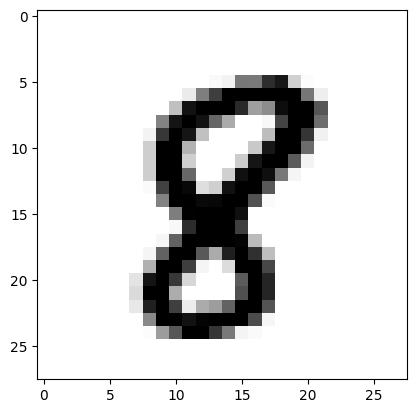

In [7]:
dataiter = iter(trainloader) # identifica se realmente é possivel ler a base de dados das imagens
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [6]:
print(imagens[0].shape) # para verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) # para verificar as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [8]:
print(imagens[0])
print(etiquetas[0])

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [9]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64)    # camada interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10)     # camada interna 2, 64 neurônios que se ligam a 10
                                             # para a camada de saida não e necessário definir nada pois só precisamos pegar o output da camada interna 2
        
    def forward(self,X):
        X = F.relu(self.linear1(X)) # função de ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para a camada interna 2
        X = self.linear3(X)         # função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
        return F.log_softmax(X, dim=1) # dados utilizados para calcular a perda

In [10]:

def treino(modelo, trainloader, device):
    
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a polítca de atualização dos pesos e da bias
    inicio = time() # timer para sabermos quanto tempo levou o treino
    
    criterio = nn.NLLLoss() # definindo o criterio para calcular a perda
    EPOCHS = 30 # numero de epochs que o algoritmo rodará
    modelo.train() # ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0 # inicialização da perda acumulada da epoch em questão
        
        for imagens, etiquetas in trainloader:
            
            imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para  "vetores" de 28*28 casas para ficarem compatíveis com a camada de entrada
            otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior
            
            output = modelo(imagens.to(device)) # colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão
            
            perda_instantanea.backward() # back propagation a partir da perda
            
            otimizador.step() # atualizando os pesos e a bias
            
            perda_acumulada += perda_instantanea.item() # atualização da perda acumulada
        
        
        else:
            print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
    print("\nTempo de treino (em minutos) =",(time()-inicio)/60)

In [11]:
modelo = Modelo() # inicializa o modelo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # modelo rodará na GPU se possível
modelo.to(device) 

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)